In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

In [2]:
nyt_datapath = '../UniversityCases/'
big10_datapath = '../../college-covid19-dataset/data'

### Import and Clean Data

New York Times - All Schools

In [3]:
fnames = sorted(glob.glob(nyt_datapath+'*.csv'))
frames = []
for f in fnames:
    m = re.search(r'[^0-9]*([0-9][0-9_]+)[^0-9]*', f)
    df = pd.read_csv(f)
    df['Date'] = pd.to_datetime(m.group(1), format='%m_%d_%y')
    df.drop(['Unnamed: 0'], axis = 1, inplace=True)
    df['Cases'] = df['Cases'].apply(lambda x: x.replace(',', '')).astype('int')
    frames.append(df)

In [4]:
nyt_df = pd.concat(frames)
nyt_df.index = pd.MultiIndex.from_frame(nyt_df[['School', 'Date']])
nyt_df.drop(['School', 'Date'], axis = 1, inplace = True)

Big 10 - All dates

In [5]:
big10_df = pd.read_csv(big10_datapath + '/daily.csv')
old_cols = big10_df.columns.values.copy()
old_cols[0] = 'School'
big10_df.columns = old_cols
big10_df['Date'] = pd.to_datetime(big10_df['Date'],format='%Y-%m-%d')

In [6]:
big10_df.index = pd.MultiIndex.from_frame(big10_df[['School', 'Date']])
big10_df.drop(['School', 'Date'], axis = 1, inplace = True)

The next process drops all repeated data -- only keeps values that are different from the day before

In [7]:
big10_df.shape

(1675, 2)

In [8]:
nyt_df.shape

(82501, 6)

In [9]:
# there is probably a much faster way to do this
# currently this takes a lot of time as it operates on each school separately
for df, test_col in [(big10_df, 'Confirmed'), (nyt_df, 'Cases')]:
    for School in df.index.levels[0]:
        msmts = df.loc[School]
        msmt_dates = msmts.index
        unchanged_dates = msmt_dates[(msmts.shift(1) == msmts)[test_col]]
        if len(unchanged_dates):
            unchanged_entries = zip(len(unchanged_dates) * [School], unchanged_dates)
            df.drop(unchanged_entries, axis = 0, inplace = True)

### Inspect Data

In [10]:
big10_df.shape

(721, 2)

In [11]:
nyt_df.shape

(7351, 6)

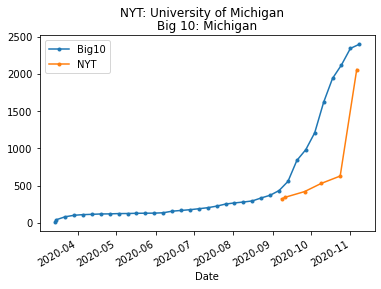

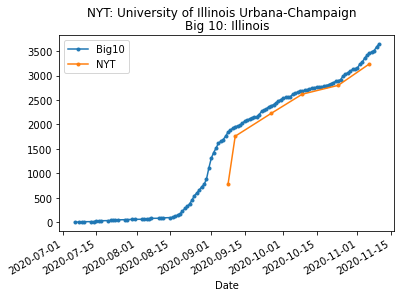

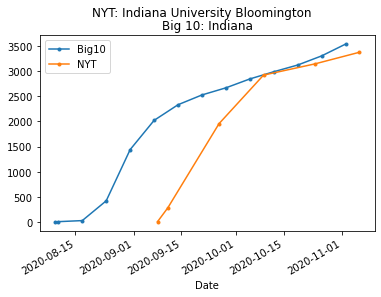

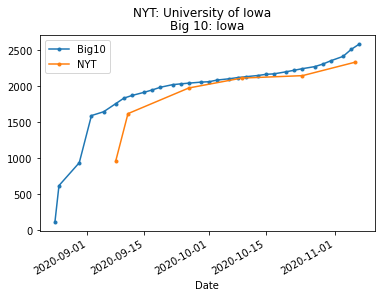

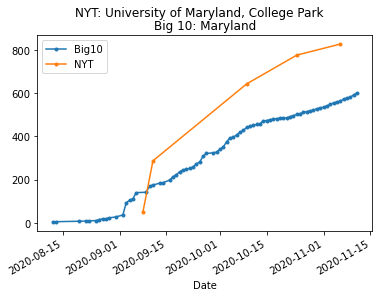

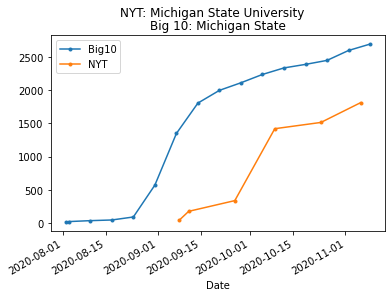

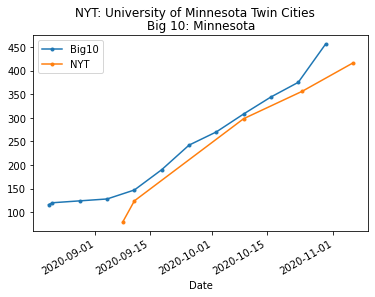

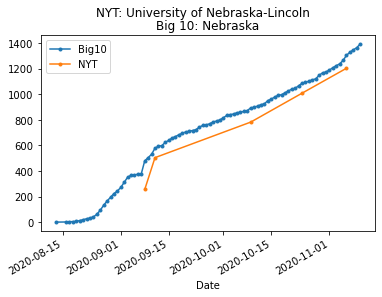

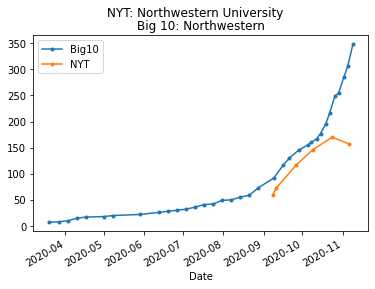

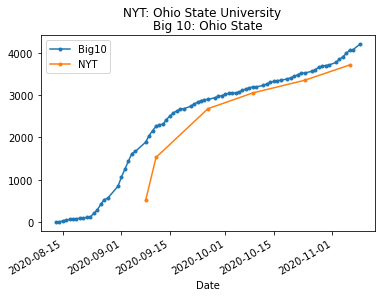

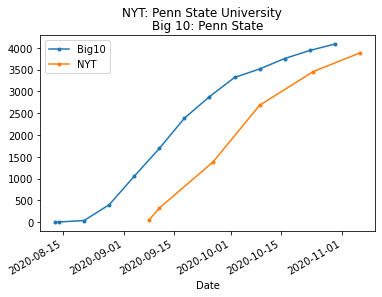

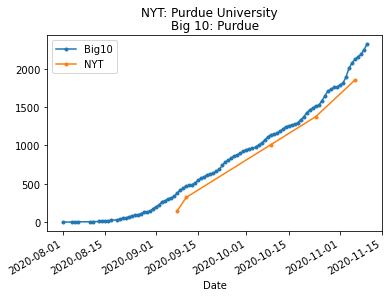

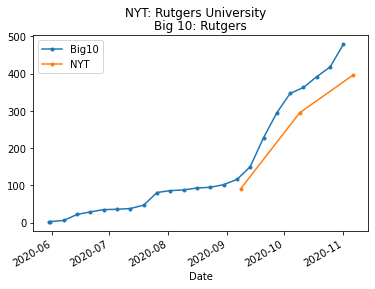

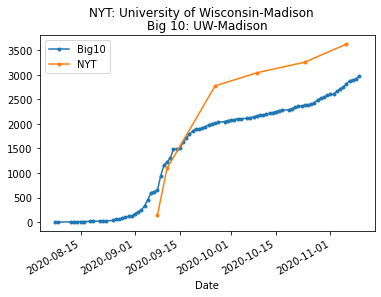

In [12]:
for b10_name, nyt_name in [('Michigan', 'University of Michigan'), 
                           ('Illinois', 'University of Illinois Urbana-Champaign'),
                           ('Indiana', 'Indiana University Bloomington'),
                           ('Iowa', 'University of Iowa'),
                           ('Maryland', 'University of Maryland, College Park'),
                           ('Michigan State', 'Michigan State University'),
                           ('Minnesota', 'University of Minnesota Twin Cities'),
                           ('Nebraska', 'University of Nebraska-Lincoln'),
                           ('Northwestern', 'Northwestern University'),
                           ('Ohio State', 'Ohio State University'),
                           ('Penn State', 'Penn State University'),
                           ('Purdue', 'Purdue University'),
                           ('Rutgers', 'Rutgers University'),
                           ('UW-Madison', 'University of Wisconsin-Madison')]:
    fig, ax = plt.subplots(1)
    big10_df.loc[b10_name]['Confirmed'].plot(style = '.-', ax = ax, label = 'Big10')
    nyt_df.loc[nyt_name]['Cases'].plot(style = '.-', ax = ax, label = 'NYT')
    plt.suptitle('NYT: {}'.format(nyt_name))
    plt.title('Big 10: {}'.format(b10_name))
    plt.legend(loc = 'best')

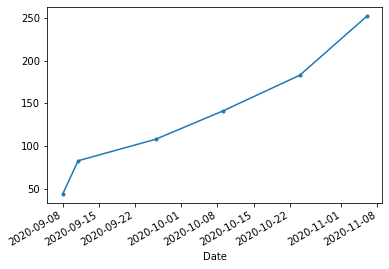

In [13]:
nyt_df.loc['Boston University']['Cases'].plot(style = '.-', label = 'NYT')